In [34]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [22]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.3 MB/s eta 0:00:0000:0100:01


In [2]:
df = pd.read_csv('/kaggle/input/click-through-rate-prediction/ad_10000records.csv')

In [3]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [4]:
df.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [5]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [7]:
df.duplicated().sum()

215

In [8]:
df = df.dropna(how='any',axis=0)

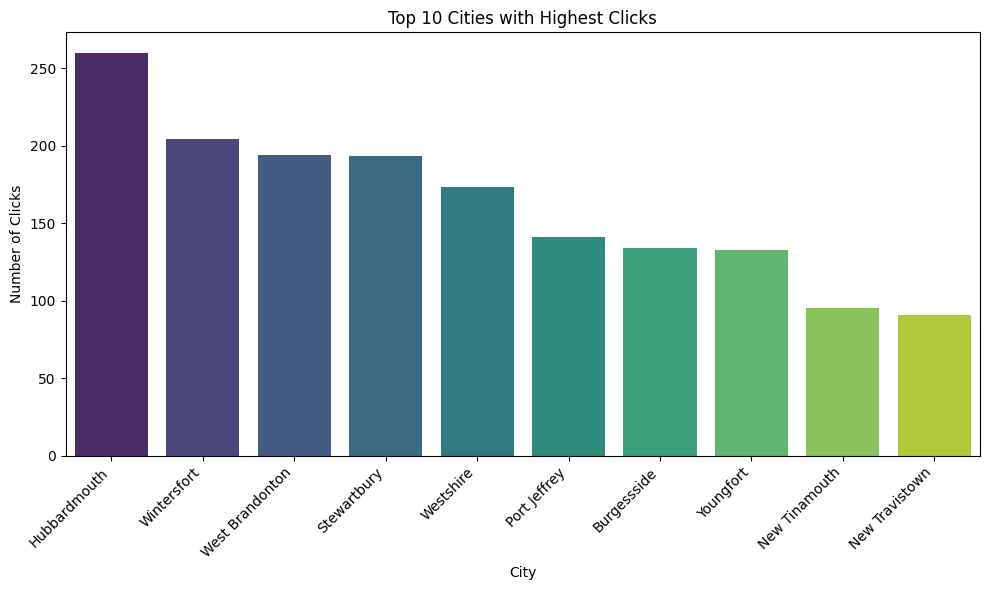

In [10]:
clicks_data = df[df['Clicked on Ad'] == 1]

# Count clicks by city
clicks_by_city = clicks_data['City'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=clicks_by_city.index, y=clicks_by_city.values, palette='viridis')
plt.title('Top 10 Cities with Highest Clicks')
plt.xlabel('City')
plt.ylabel('Number of Clicks')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


this plot shows the top 10 cities that clicked on the ad

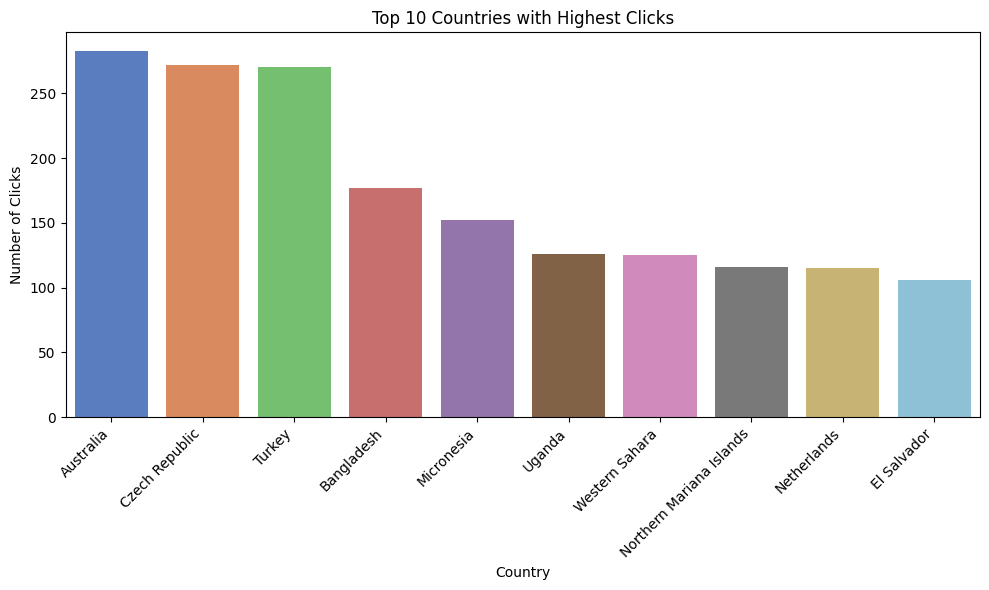

In [11]:
clicks_data = df[df['Clicked on Ad'] == 1]
clicks_by_country = clicks_data['Country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=clicks_by_country.index, y=clicks_by_country.values, palette='muted')
plt.title('Top 10 Countries with Highest Clicks')
plt.xlabel('Country')
plt.ylabel('Number of Clicks')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()


and this one shows the top 10 countries that clicked on the ad

In [12]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Hour_normalized'] = df['Hour'] / 23.0  # Dividing by maximum hour value
df['Minute_normalized'] = df['Minute'] / 59.0  # Dividing by maximum minute value
df.drop(columns=['Timestamp'], inplace=True)

this part of the code extacts the Year, month, Day, Hour and the minute from the 'Timestamp' column and adds them as new individual columns and then drops the 'Timestamp'If the dataset includes a timeline or time-based feature, it should be transformed into useful features. For example, extracting the hour, day, month, or even whether the timestamp falls on a weekday or weekend can provide additional context for the model.

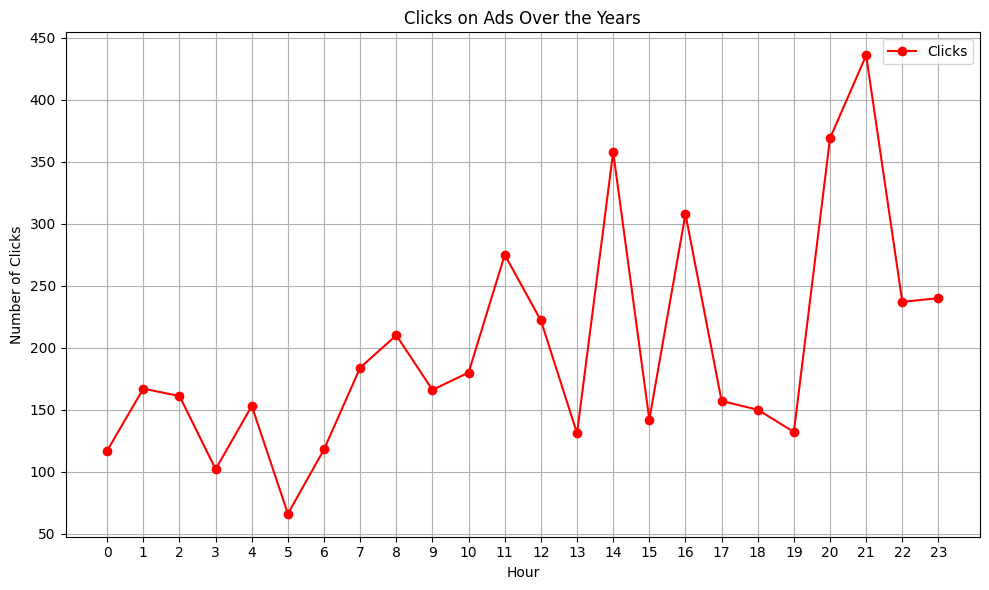

In [13]:
clicks_over_years = df.groupby('Hour')['Clicked on Ad'].sum()
plt.figure(figsize=(10, 6))
plt.plot(clicks_over_years.index, clicks_over_years.values, marker='o', linestyle='-', color='r', label='Clicks')
plt.title('Clicks on Ads Over the Years')
plt.xlabel('Hour')
plt.ylabel('Number of Clicks')
plt.xticks(clicks_over_years.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


and this plot describes the click on ads over time(Hour)

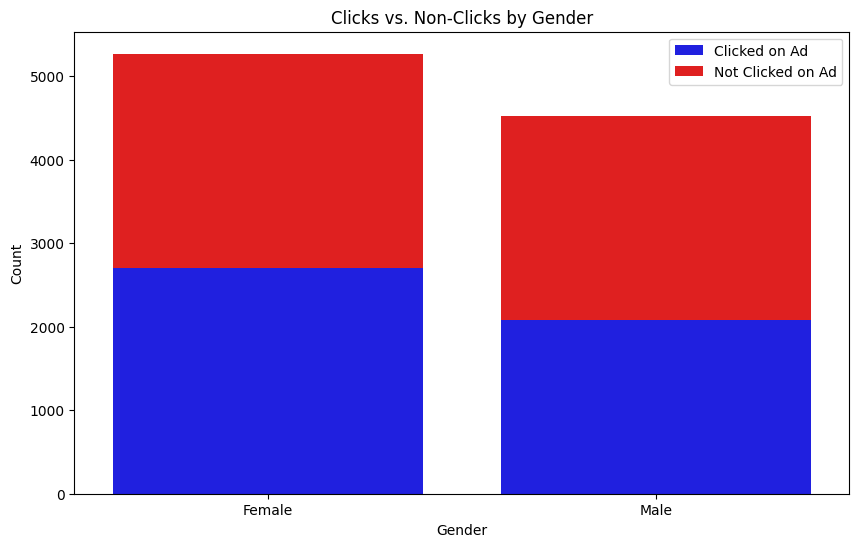

In [14]:
gender_clicks = df.groupby(['Gender', 'Clicked on Ad']).size().reset_index(name='count')
gender_clicks_pivot = gender_clicks.pivot(index='Gender', columns='Clicked on Ad', values='count').fillna(0)

plt.figure(figsize=(10, 6))
sns.barplot(x=gender_clicks_pivot.index, y=gender_clicks_pivot[1], color='blue', label='Clicked on Ad')
sns.barplot(x=gender_clicks_pivot.index, y=gender_clicks_pivot[0], color='red', bottom=gender_clicks_pivot[1], label='Not Clicked on Ad')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Clicks vs. Non-Clicks by Gender')
plt.legend()
plt.show()


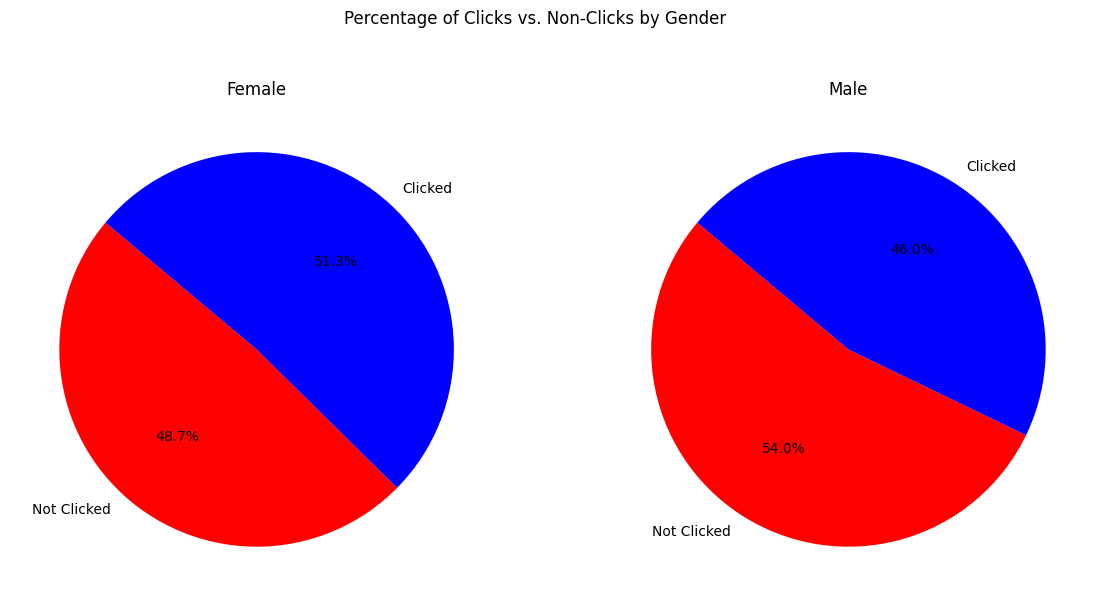

In [16]:
gender_clicks = df.groupby(['Gender', 'Clicked on Ad']).size().reset_index(name='count')
gender_clicks_pivot = gender_clicks.pivot(index='Gender', columns='Clicked on Ad', values='count').fillna(0)
gender_clicks_pivot['total'] = gender_clicks_pivot.sum(axis=1)
gender_clicks_pivot[0] = (gender_clicks_pivot[0] / gender_clicks_pivot['total']) * 100
gender_clicks_pivot[1] = (gender_clicks_pivot[1] / gender_clicks_pivot['total']) * 100
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for i, gender in enumerate(gender_clicks_pivot.index):
    axes[i].pie(
        gender_clicks_pivot.loc[gender, [0, 1]], 
        labels=['Not Clicked', 'Clicked'], 
        autopct='%1.1f%%', 
        colors=['red', 'blue'],
        startangle=140
    )
    axes[i].set_title(f'{gender}')

plt.suptitle('Percentage of Clicks vs. Non-Clicks by Gender')
plt.show()


these ones simply shows how many male and female audience clicke or did not click on the ad 

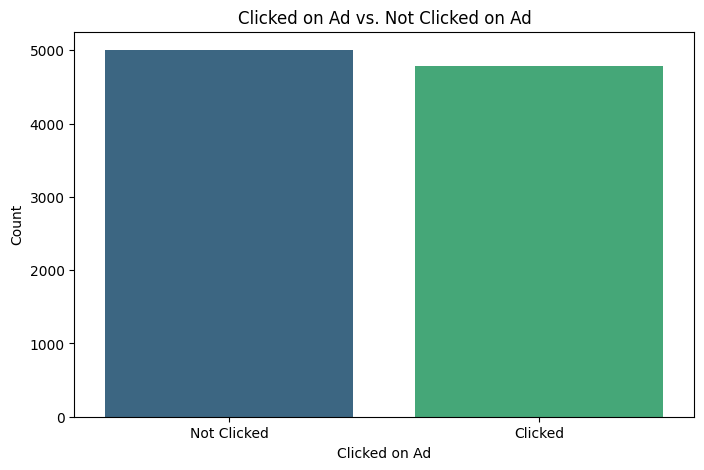

In [17]:
clicked_counts = df['Clicked on Ad'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=clicked_counts.index, y=clicked_counts.values, palette='viridis')
plt.xticks(ticks=[0, 1], labels=['Not Clicked', 'Clicked'])
plt.xlabel('Clicked on Ad')
plt.ylabel('Count')
plt.title('Clicked on Ad vs. Not Clicked on Ad')
plt.show()


the number of clicked and not clicked rows in the column.

In [18]:
df['Year'].unique

<bound method Series.unique of 0       2016
1       2016
2       2016
3       2016
4       2016
        ... 
9994    2016
9995    2016
9996    2016
9997    2016
9998    2016
Name: Year, Length: 9785, dtype: int32>

In [19]:
df['Country'].unique()

array(['Svalbard & Jan Mayen Islands', 'Singapore', 'Guadeloupe',
       'Zambia', 'Qatar', 'Cameroon', 'Turkey', 'French Guiana',
       'Vanuatu', 'Burundi', 'Equatorial Guinea', 'Guinea', 'Hong Kong',
       'Spain', 'Uganda', 'Saint Pierre and Miquelon',
       'Northern Mariana Islands', 'Western Sahara', 'Mexico', 'Rwanda',
       'Liechtenstein', 'Bolivia', 'Indonesia', 'Angola', 'Gabon',
       'Saint Vincent and the Grenadines', 'Hungary', 'Honduras',
       'Denmark', 'Tajikistan', 'Afghanistan', 'Micronesia',
       'French Polynesia', 'Tonga', 'Myanmar', 'Croatia', 'Australia',
       'Algeria', 'Greece', 'Bangladesh', 'Latvia', 'Belgium',
       'Czech Republic', 'Cuba', 'Namibia', 'Madagascar', 'Brazil',
       'Barbados', 'Ghana', 'Netherlands', 'Belize', 'American Samoa',
       'Albania', 'Luxembourg', 'Austria', 'Mongolia', 'Ireland',
       'United States Minor Outlying Islands', 'Iran',
       'United Arab Emirates', 'Cambodia', 'Chile', 'South Africa',
       'Esto

In [95]:
manual_mapping = {
    'ao Tome and Principe': 'Sao Tome and Principe',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Russian Federation': 'Russia',
    'Palestinian Territory': 'Palestine',
    'Syrian Arab Republic': 'Syria',
    'Falkland Islands (Malvinas)': 'Falkland Islands',
    'Heard Island and McDonald Islands': 'Heard Island and McDonald Islands',
    'Pitcairn Islands': 'Pitcairn Islands',
    'South Georgia and the South Sandwich Islands': 'South Georgia and the South Sandwich Islands',
}

def standardize_country_name(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.name
    except LookupError:
        return manual_mapping.get(country_name, country_name)
df['Country'] = df['Country'].apply(standardize_country_name)

print("DataFrame after standardizing country names:")
print(df[['Country']].drop_duplicates().reset_index(drop=True))

DataFrame after standardizing country names:
                          Country
0    Svalbard & Jan Mayen Islands
1                       Singapore
2                      Guadeloupe
3                          Zambia
4                           Qatar
..                            ...
202                    Montserrat
203                        Bhutan
204   Falkland Islands (Malvinas)
205                         Haiti
206                    Martinique

[207 rows x 1 columns]


this cell block creates a mapping that renames some of the country names in the country column

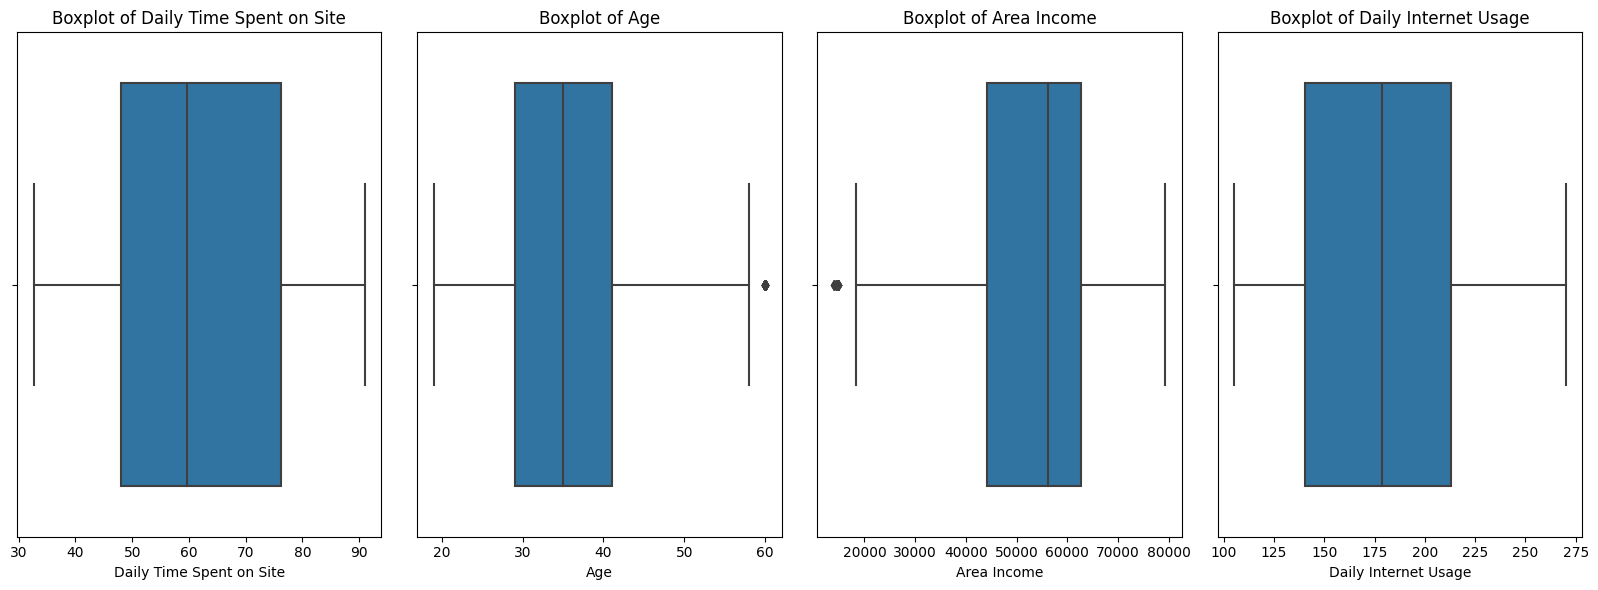

In [25]:
columns_to_plot = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(16, 6))
for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

acording to these box plots two of the features have a few outlies which will be removed 

In [26]:
def remove_outliers(df, columns):
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df = df[(z_scores < 3)]  # Keep only values within 3 standard deviations
    return df

In [27]:
numeric_columns = ['Age', 'Area Income']
df = remove_outliers(df, numeric_columns)

In [29]:
word_freq = {}
for line in df['Ad Topic Line']:
    for word in line.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

df['Ad Topic Frequency'] = df['Ad Topic Line'].apply(lambda x: sum(word_freq[word] for word in x.split()))
df.drop('Ad Topic Line', inplace=True, axis=1)

The Ad Topic Line feature was handled by calculating the frequency of words in each ad topic line and creating a new feature Ad Topic Frequency.This approach captures the relevance and commonality of words in ad topics, providing a numerical representation of ad content.

In [30]:
df = pd.get_dummies(df, columns=['City', 'Country'], drop_first=True)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.drop('Gender', inplace = True, axis=1)

The categorical variables City and Country were encoded using one-hot encoding, which creates binary columns for each category, allowing the model to learn from these features without assuming any ordinal relationship.

The Gender variable was encoded using label encoding, which assigns a unique integer to each category.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9785 entries, 0 to 9998
Columns: 739 entries, Daily Time Spent on Site to Country_Zimbabwe
dtypes: bool(726), float64(6), int32(5), int64(2)
memory usage: 7.6 MB


In [32]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad,Year,Month,Day,Hour,Minute,Hour_normalized,Minute_normalized,Ad Topic Frequency
count,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.0,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000
mean,61.601379,35.839550,53948.143348,177.886144,0.488605,2016.0,3.860603,14.382115,12.312928,27.391109,0.535345,0.464256,539.101686
std,15.698216,8.538524,13360.051625,40.861875,0.499896,0.0,1.996058,8.593459,7.067524,17.724198,0.307284,0.300410,253.233879
min,32.600000,19.000000,13996.500000,105.220000,0.000000,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,46.000000
25%,48.030000,29.000000,44174.250000,140.150000,0.000000,2016.0,2.000000,7.000000,6.000000,12.000000,0.260870,0.203390,350.000000
50%,59.590000,35.000000,56180.930000,178.920000,0.000000,2016.0,4.000000,14.000000,13.000000,25.000000,0.565217,0.423729,501.000000
75%,76.270000,41.000000,62669.590000,212.870000,1.000000,2016.0,6.000000,21.000000,19.000000,43.000000,0.826087,0.728814,654.000000
max,90.970000,60.000000,79332.330000,269.960000,1.000000,2016.0,7.000000,31.000000,23.000000,59.000000,1.000000,1.000000,1250.000000


In [35]:
X = df.drop(columns=['Clicked on Ad'])
y = df['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_svc = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', SVC(random_state=42))
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', LogisticRegression(random_state=42))
])

models = {
    'Random Forest': pipeline_rf,
    'Support Vector Machine': pipeline_svc,
    'Logistic Regression': pipeline_lr
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}:")
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}\n")

pipeline_rf.fit(X_train, y_train)
pipeline_svc.fit(X_train, y_train)
pipeline_lr.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svc = pipeline_svc.predict(X_test)
y_pred_lr = pipeline_lr.predict(X_test)

print("Performance on test data:")
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Support Vector Machine:")
print(classification_report(y_test, y_pred_svc))
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Evaluating Random Forest:
Cross-validation scores: [0.88697318 0.86462324 0.8550447  0.87348243 0.86773163]
Mean accuracy: 0.8696

Evaluating Support Vector Machine:
Cross-validation scores: [0.84802043 0.84546616 0.84291188 0.86964856 0.85750799]
Mean accuracy: 0.8527

Evaluating Logistic Regression:
Cross-validation scores: [0.84993614 0.8550447  0.8550447  0.87220447 0.8600639 ]
Mean accuracy: 0.8585

Performance on test data:
Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1011
           1       0.89      0.86      0.88       946

    accuracy                           0.88      1957
   macro avg       0.88      0.88      0.88      1957
weighted avg       0.88      0.88      0.88      1957

Support Vector Machine:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1011
           1       0.84      0.84      0.84       946

    accuracy                        

Random Forest had the highest accuracy and was the best-performing model, followed by Logistic Regression and SVM.

New features were created based on existing ones if they were expected to add predictive power.
Ratio Features: Creating features like the ratio of Daily Time Spent on Site to Daily Internet Usage can highlight users' engagement levels.
Interaction Features: Multiplying or adding features can create interaction terms that capture combined effects of multiple variables.